In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
import sys
sys.path.append('..')

# from io import BytesIO
# from IPython import display
# from IPython.display import Image
# from ipywidgets import widgets, interact, interactive, fixed

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.nn import MSELoss

from src.datamodules import SN7DataModule
from src.datasources import S2_BANDS12
from src.lanczos import lanczos_shift, lanczos_kernel
from src.plot import show
from src.registered_loss import RegisteredLoss, ShiftConv2d

In [3]:
def shape(name):
    val = eval(name)
    print(f'{name} : {tuple(val.shape)}')

---
# Discrete shift kernels

K_y : (5, 1, 1, 11, 1)
K_x : (5, 1, 1, 1, 11)
K : (25, 1, 1, 11, 11)


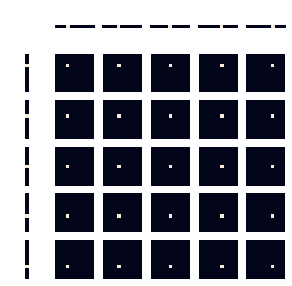

In [4]:
w = 4
start, end, step = -(w/2), w/2, 1

shiftconv2d = ShiftConv2d(start, end, step)
K_y = shiftconv2d.K_y
K_x = shiftconv2d.K_x
K = torch.stack([k_y * k_x for k_y, k_x in product(K_y, K_x)])

shape('K_y')
shape('K_x')
shape('K')

r = w + 1
_, ax = plt.subplots(r + 1, r + 1, figsize=(r, r));
show(torch.Tensor([[]]), ax=ax[[0],[0]])
show(K_x[:, 0], axis=False, ax=ax[0, 1:])
show(K_y[:, 0], axis=False, ax=ax[1:, 0])
show(K[:, 0], rows=r, axis=False, ax=ax[1:,1:].flatten())

---
## Two colored examples

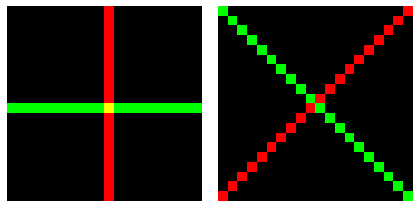

In [5]:
d = 20
img1 = torch.zeros((3, d, d))
img1[[0], :, d//2] = 1
img1[[1], d//2, :] = 1
img2 = torch.zeros(3, d, d)
img2[0, :, :] = .5 * torch.eye(d).fliplr()
img2[1, :, :] = .5 * torch.eye(d)

show([img1, img2], axis=False)

All shifted versions of the input:

x : (2, 3, 20, 20)
x_shifted : (2, 25, 3, 20, 20)


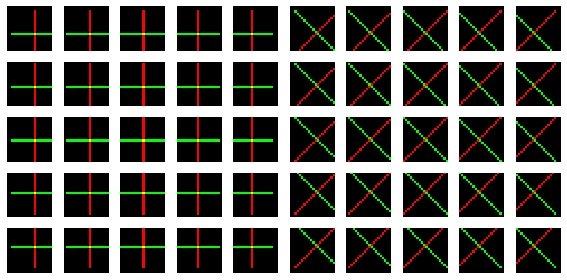

In [6]:
x = torch.stack([img1, img2])
shape("x")

reg_mse = RegisteredLoss(start, end, step=1, loss_func=MSELoss(reduction='none'), reduction='none')
x_shifted = reg_mse._shiftconv2d(x)
shape("x_shifted")

_, S, _, H, W = x_shifted.shape
r = int(S**.5)
img = (torch.cat([x_shifted[0].view(r, r, 3, H, W),
                  x_shifted[1].view(r, r, 3, H, W)], dim=1)
       .view(2 * r * r, 3, H, W)
      ).detach()

show(img.clamp(0, 1), rows=5, axis=False, figsize=.8)

---

Suppose we have the following two **ground-truth targets**:

y : (2, 3, 20, 20)


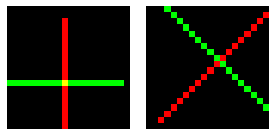

In [7]:
y = torch.cat([x_shifted[0, [3]], x_shifted[1, [15]]])#.detach()
shape('y')

show(y.clamp(0, 1), axis=False, figsize=2)

Then these would be their optimum shifts:

loss_all_shifts : (2, 25)


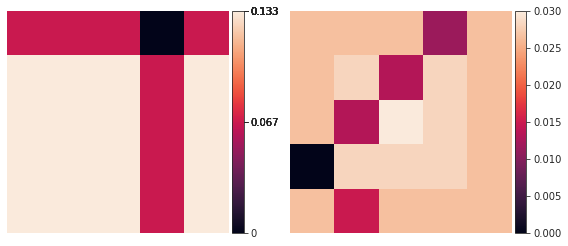

In [8]:
loss_all_shifts = reg_mse._shifted_loss(x, y).detach()
shape('loss_all_shifts')

x1 = loss_all_shifts.reshape(2, 5, 5)[0]
x2 = loss_all_shifts.reshape(2, 5, 5)[1]

show([x1, x2], axis=False, figsize=4, colorbar=True, normalize=False)

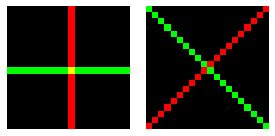

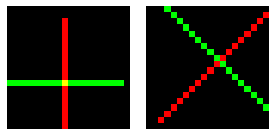

In [9]:
show(x.clamp(0,1), axis=False, figsize=2)
show(y.clamp(0,1), axis=False, figsize=2)

In [10]:
print(MSELoss(reduction='none')(x, y).mean((-3,-2,-1)))
print(reg_mse(x, y))

tensor([0.0642, 0.0156])
tensor([0., 0.])


---

## Trying it on actual data

In [11]:
date_range = pd.date_range(start='2019-12-31', end='2020-01-31')
dm = SN7DataModule(date_range=date_range, s2_bands=S2_BANDS12['true_color'],
                   window_size_planet=64, samples=1_000, batch_size=1,
                   normalize=True, debug=1)
dm.setup()

sr : (1, 3, 64, 64)
hr : (1, 3, 64, 64)
lr : (1, 3, 30, 31)


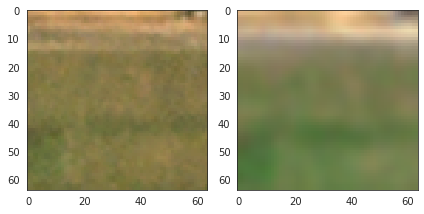

In [12]:
# item = next(iter(dm.train_dataloader()))
item = dm.dataset_train[0]
hr, lr = item['highres']['images'], item['lowres']['images']

sr = cv2.resize(lr[0].permute(1,2,0).numpy(), dsize=(64, 64)).transpose(2,0,1)[None]
sr = torch.from_numpy(sr)

shape('sr')
shape('hr')
shape('lr')

show([hr, sr])

mse_all_shifts : (1, 25)


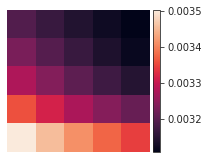

In [13]:
w = 4
start, end, step = -(w/2), w/2, 1
mse = MSELoss(reduction='none')
reg_mse = RegisteredLoss(start, end, step, loss_func=mse, reduction='none')
mse_all_shifts = reg_mse._shifted_loss(sr, hr).detach()
shape('mse_all_shifts')

show(mse_all_shifts.view(w + 1, w + 1), axis=False, figsize=3, colorbar=True, normalize=False)

In [14]:
print(mse(sr[..., w:-w, w:-w], hr[..., w:-w, w:-w]).mean((-3,-2,-1)))
print(reg_mse(sr, hr))

tensor([0.0032])
tensor([0.0031])


# Sub-pixel shift kernels

K_y : (7, 1, 1, 9, 1)
K_x : (7, 1, 1, 1, 9)
K : (49, 1, 1, 9, 9)


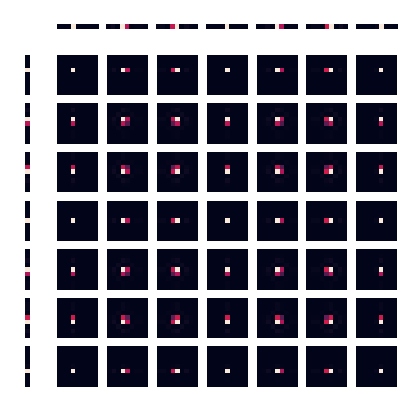

In [15]:
w = 2
start, end, step = -(w/2), w/2, .33
shiftconv2d = ShiftConv2d(start, end, step)
K_y = shiftconv2d.K_y
K_x = shiftconv2d.K_x
K = torch.stack([k_y * k_x for k_y, k_x in product(K_y, K_x)])

shape('K_y')
shape('K_x')
shape('K')

_, ax = plt.subplots(K_y.shape[0]+1, K_x.shape[0]+1, figsize=(K_y.shape[0], K_x.shape[0]));
show(torch.Tensor([[]]), ax=ax[[0],[0]])
show(K_x[:, 0], axis=False, ax=ax[0, 1:])
show(K_y[:, 0], axis=False, ax=ax[1:, 0])
show(K[:, 0], rows=K_y.shape[0]+1, axis=False, ax=ax[1:,1:].flatten())

x : (2, 3, 20, 20)


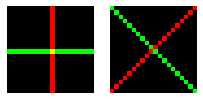

In [16]:
x = torch.stack([img1, img2])
show(x, axis=False, figsize=1.5)
shape('x')

In [17]:
shape('x')
x_shifted = shiftconv2d(x)
shape('x_shifted')

x : (2, 3, 20, 20)
x_shifted : (2, 49, 3, 20, 20)


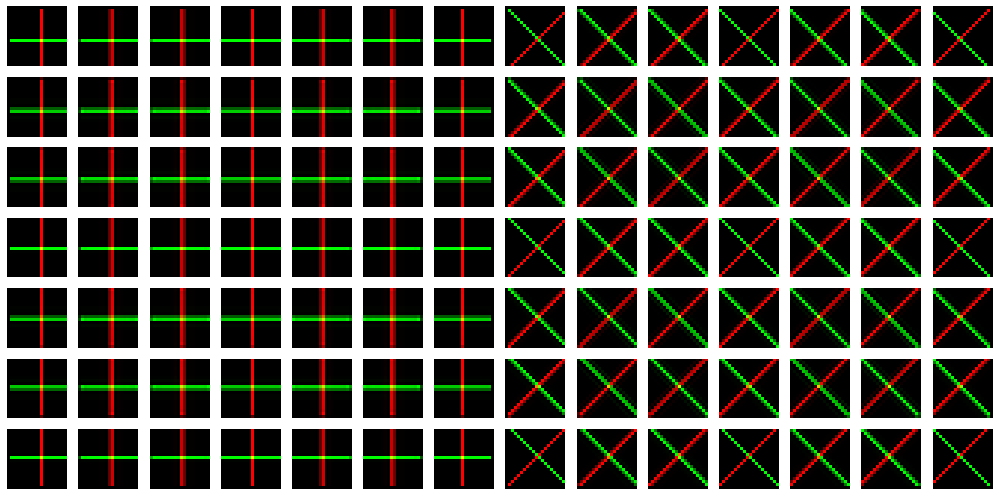

In [24]:
_, S, _, H, W = x_shifted.shape
w = int(S**.5)
img = (torch.cat([x_shifted[0].view(w, w, 3, H, W),
                  x_shifted[1].view(w, w, 3, H, W)], dim=1)
       .view(2 * w * w, 3, H, W)
      ).detach()

show(img.clamp(0, 1), rows=w, axis=False, figsize=1)

## Trying it on actual data

sr : (1, 3, 64, 64)
hr : (1, 3, 64, 64)
lr : (1, 3, 30, 30)
mse_all_shifts : (1, 49)


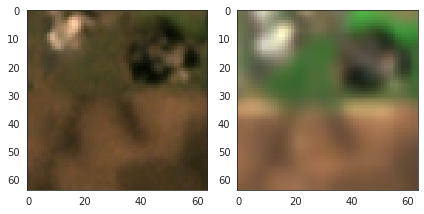

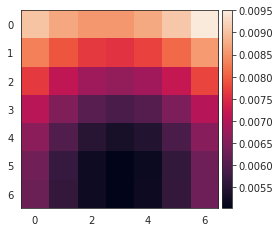

In [38]:
item = dm.dataset_train[1]
hr, lr = item['highres']['images'], item['lowres']['images']

sr = cv2.resize(lr[0].permute(1,2,0).numpy(), dsize=(64, 64)).transpose(2,0,1)[None]
sr = torch.from_numpy(sr)

shape('sr')
shape('hr')
shape('lr')

show([hr, sr])

w = 6
start, end, step = -(w/2), w/2, 1
mse = MSELoss(reduction='none')

reg_mse = RegisteredLoss(start, end, step, loss_func=mse, reduction='none')

mse_all_shifts = reg_mse._shifted_loss(sr, hr).detach()
shape('mse_all_shifts')

rows = round(mse_all_shifts.shape[1]**.5)
show(mse_all_shifts.view(rows, rows), axis=True, figsize=4, colorbar=True, normalize=False)

In [39]:
print(mse(sr[..., w:-w, w:-w], hr[..., w:-w, w:-w]).mean((-3,-2,-1)))
print(reg_mse(sr, hr))

tensor([0.0059])
tensor([0.0050])


In [40]:
shape('sr')
sr_shifted = reg_mse._shiftconv2d(sr)
shape('sr_shifted')

sr : (1, 3, 64, 64)
sr_shifted : (1, 49, 3, 64, 64)


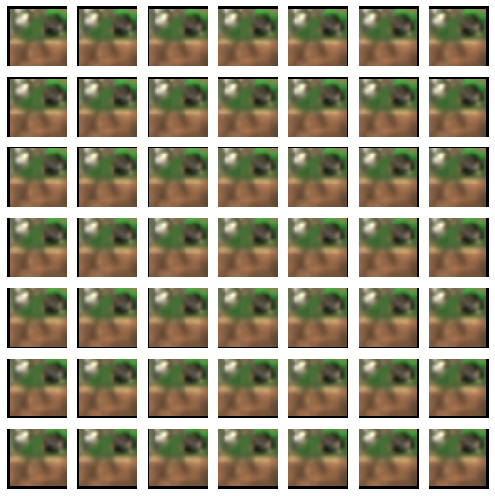

In [41]:
r = int(sr_shifted.shape[1]**.5)
show(sr_shifted[0].clamp(0, 1), rows=r, axis=False, figsize=1)

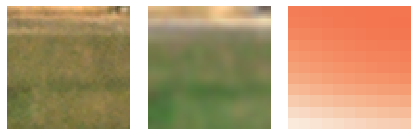

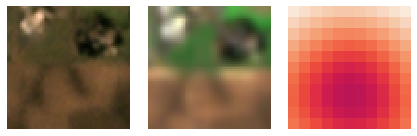

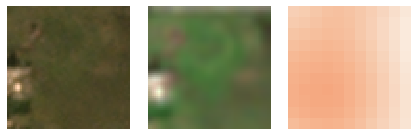

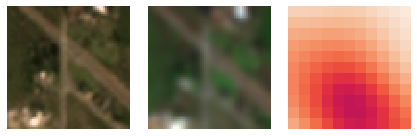

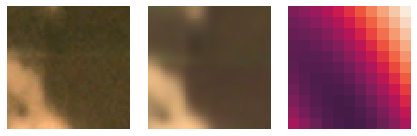

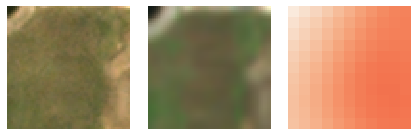

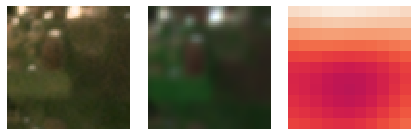

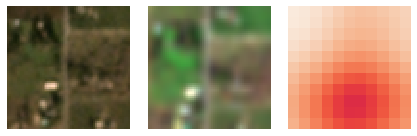

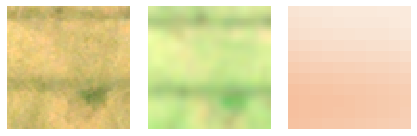

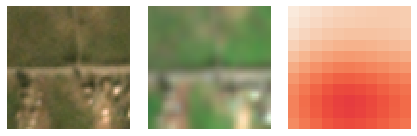

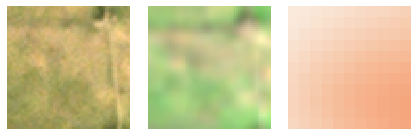

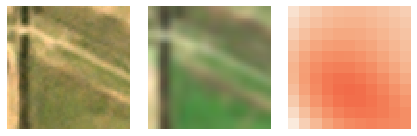

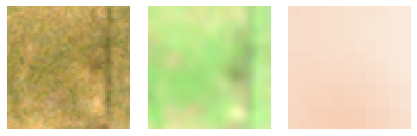

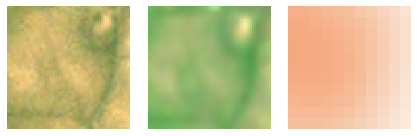

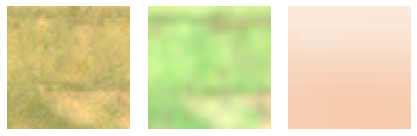

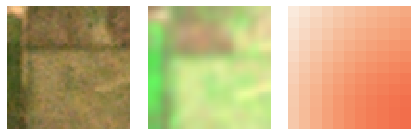

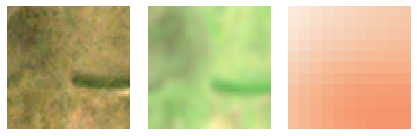

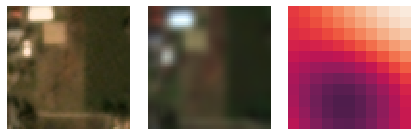

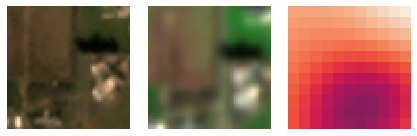

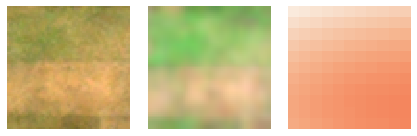

In [55]:
for i in range(20):
    item = dm.dataset_train[i]
    hr, lr = item['highres']['images'], item['lowres']['images']

    sr = cv2.resize(lr[0].permute(1,2,0).numpy(), dsize=(64, 64)).transpose(2,0,1)[None]
    sr = torch.from_numpy(sr)

    w = 10
    start, end, step = -(w/2), w/2, 1
    mse = MSELoss(reduction='none')

    reg_mse = RegisteredLoss(start, end, step, loss_func=mse, reduction='none')

    mse_all_shifts = reg_mse._shifted_loss(sr, hr).detach()
    heatmap = mse_all_shifts.view(rows, rows)

    rows = round(mse_all_shifts.shape[1]**.5)
    show([hr, sr, heatmap], axis=False, figsize=2, colorbar=False, normalize=True)